In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
#### Loading images matrix
data_images = np.load('images_data.npy')
print(data_images.shape)

### Loading labels data
data_labels = np.load('labels.npy')
print(data_labels.shape)

(1000, 28, 28)
(1000, 2)


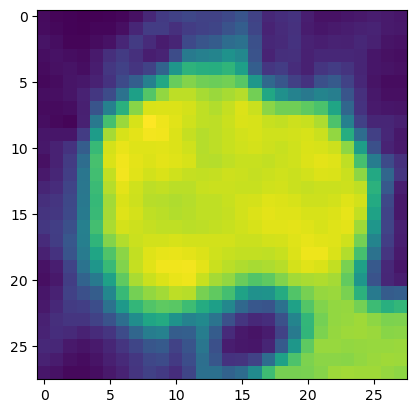

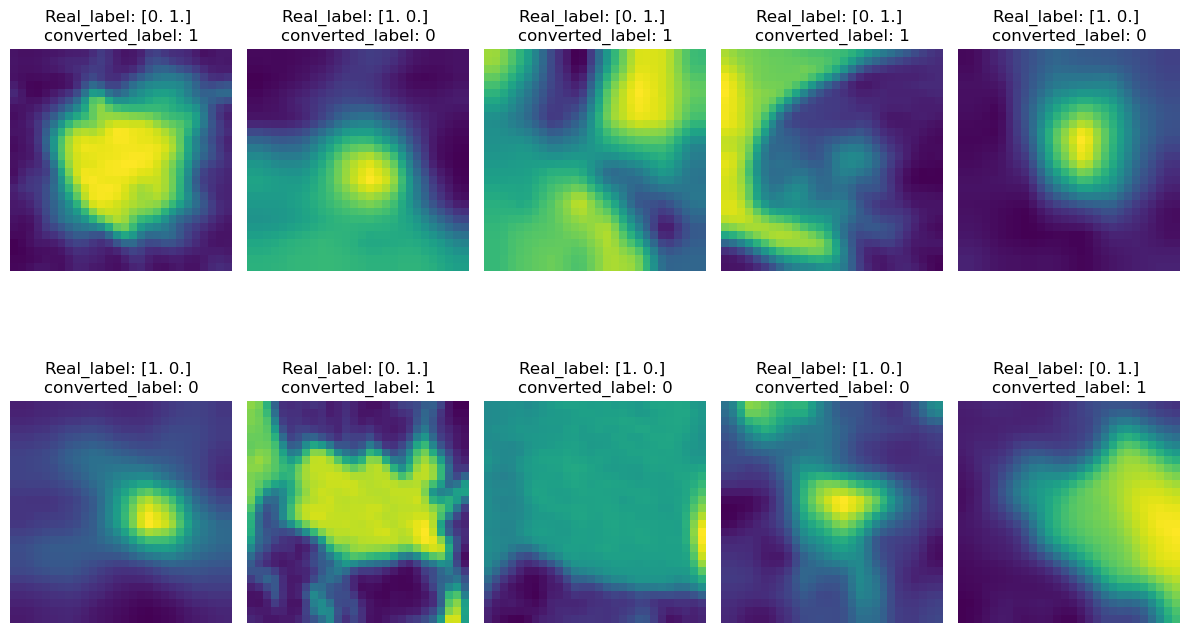

Number of class 0: 447
Number of class 1: 553


In [3]:
data_images = data_images/255.0
plt.figure()
plt.imshow(data_images[2])

# Select 10 random indices from the test set
random_indices = np.random.choice(len(data_images), size=10, replace=False)

# Plot the 10 random images with real and predicted labels
plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(data_images[idx, :, :])
    real_label = (data_labels[idx])
    real_label_convert = np.argmax(data_labels[idx])
    plt.title(f'Real_label: {real_label} \nconverted_label: {real_label_convert}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Inspect the labels
class_1 = []
class_0 = []
for i in range(len(data_labels)):
  if(np.argmax(data_labels[i])):
    class_1.append(data_labels[i])
  else:
    class_0.append(data_labels[i])

print("Number of class 0:", len(class_0))
print("Number of class 1:", len(class_1))

In [4]:
from sklearn.model_selection import train_test_split

# Reshape the image array and add a channel dimension
image_array = np.expand_dims(data_images, axis=-1)

# Splitting the data
train_images, temp_images, train_labels, temp_labels = train_test_split(image_array, data_labels, test_size=0.4, random_state=42)
validation_images, test_images, validation_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=42)

print("Training Images Shape:", train_images.shape)
print("Validation Images Shape:", validation_images.shape)
print("Testing Images Shape:", test_images.shape)
print("Training Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", validation_labels.shape)
print("Testing Labels Shape:", test_labels.shape)

print(train_labels)

Training Images Shape: (600, 28, 28, 1)
Validation Images Shape: (200, 28, 28, 1)
Testing Images Shape: (200, 28, 28, 1)
Training Labels Shape: (600, 2)
Validation Labels Shape: (200, 2)
Testing Labels Shape: (200, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [5]:
# Define the Residual Block
def residual_block(x, filters, stride=1, identity=True):
    shortcut = x
    
    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    
    if identity:
        if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
            shortcut = Conv2D(filters, (1, 1), strides=stride, padding='valid')(shortcut)
            shortcut = BatchNormalization()(shortcut)
        x = Add()([x, shortcut])
    else:
        x = x

    x = Activation('relu')(x)
    
    return x

In [6]:
# Create the ResNet model
def create_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)
    return model

In [7]:
def create_resnetV2(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)  # Add dropout for regularization
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)
    return model

In [8]:
def create_vggnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten and fully connected layers
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)
    return model

In [9]:
# Define the AlexNet model
def create_alexnet(input_shape, num_classes):
    model = tf.keras.Sequential()

    # Layer 1
    model.add(Conv2D(96, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 3
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))

    # Layer 4
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))

    # Layer 5
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output from convolutional layers
    model.add(Flatten())

    # Layer 6
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Layer 7
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [10]:
# Specify input shape and number of classes
input_shape = (28, 28, 1)
num_classes = 2

# Create CNN model
# model = create_resnetV2(input_shape, num_classes)
# model = create_vggnet(input_shape, num_classes)
model = create_alexnet(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 96)        960       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       221440    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 384)         1

Epoch 1/50


2023-11-11 21:08:11.371617: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


19/19 [==============================] - 5s 225ms/step - loss: 0.7152 - accuracy: 0.5100 - val_loss: 0.6914 - val_accuracy: 0.5600
Epoch 2/50
19/19 [==============================] - 5s 239ms/step - loss: 0.6897 - accuracy: 0.5583 - val_loss: 0.6848 - val_accuracy: 0.5600
Epoch 3/50
19/19 [==============================] - 4s 234ms/step - loss: 0.6662 - accuracy: 0.5833 - val_loss: 0.5831 - val_accuracy: 0.7400
Epoch 4/50
19/19 [==============================] - 5s 271ms/step - loss: 0.6667 - accuracy: 0.6267 - val_loss: 0.6616 - val_accuracy: 0.5600
Epoch 5/50
19/19 [==============================] - 5s 238ms/step - loss: 0.6716 - accuracy: 0.5583 - val_loss: 0.6152 - val_accuracy: 0.5600
Epoch 6/50
19/19 [==============================] - 5s 246ms/step - loss: 0.6689 - accuracy: 0.6050 - val_loss: 0.5657 - val_accuracy: 0.7150
Epoch 7/50
19/19 [==============================] - 4s 233ms/step - loss: 0.5646 - accuracy: 0.7333 - val_loss: 0.5830 - val_accuracy: 0.7100
Epoch 8/50
19/19 

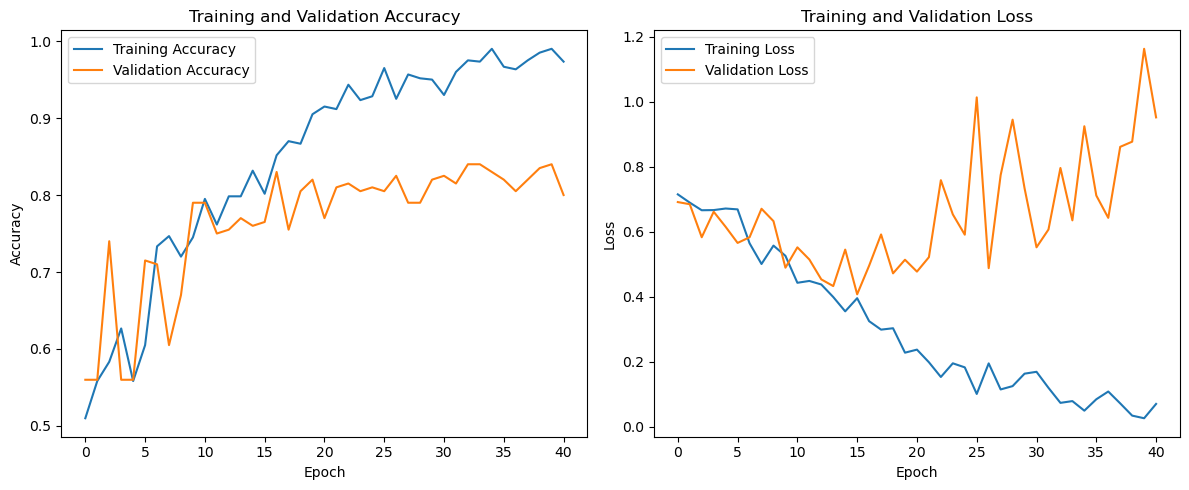

In [12]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
history = model.fit(train_images, train_labels, epochs=50, batch_size=32, validation_data=(validation_images, validation_labels), callbacks=[early_stopping])

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

7/7 [==============================] - 1s 68ms/step


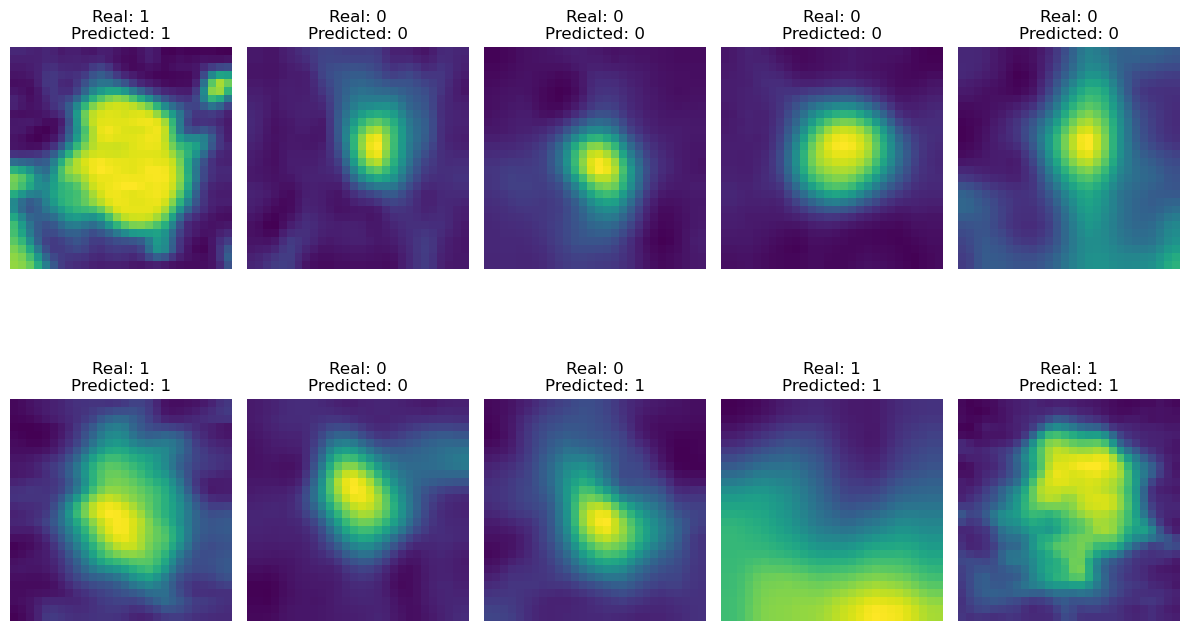

In [13]:
# Make predictions on the test set
predictions = model.predict(test_images)

# Select 10 random indices from the test set
random_indices = np.random.choice(len(test_images), size=10, replace=False)

# Plot the 10 random images with real and predicted labels
plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[idx, :, :, 0])
    real_label = np.argmax(test_labels[idx])
    predicted_label = np.argmax(predictions[idx])
    plt.title(f'Real: {real_label}\nPredicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Confusion Matrix:
[[ 64  30]
 [  6 100]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.68      0.78        94
           1       0.77      0.94      0.85       106

    accuracy                           0.82       200
   macro avg       0.84      0.81      0.81       200
weighted avg       0.84      0.82      0.82       200



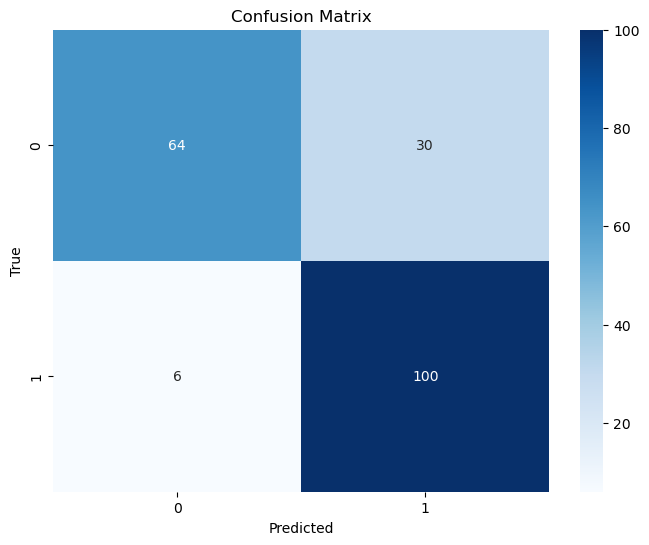

In [14]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
print('Confusion Matrix:')
print(conf_matrix)

# Calculate classification report
class_report = classification_report(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
print('Classification Report:')
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()